# Profile

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

datadir = '../../../../Data/RSNA_2022_DATA/rsna-2022-cervical-spine-fracture-detection'
libdir = '.'
outputdir = '.'
otherdir = '.'

train_bs_ = 16 # train_batch_size
valid_bs_ = 32 # valid_batch_size
num_workers_ = 5

# CFG

In [5]:
class CFG:
    seed=42
    device='GPU'
    nprocs=1 
    num_workers=num_workers_
    train_bs=train_bs_
    valid_bs=valid_bs_
    fold_num=5 
    
    target_cols=["C1", "C2", "C3", "C4", "C5", "C6", "C7", "OT"]
    num_classes=8 
    
    accum_iter=1 
    max_grad_norm=1000 
    print_freq=100 
    normalize_mean=[0.4824, 0.4824, 0.4824] 
    normalize_std=[0.22, 0.22, 0.22] 
    
    suffix="109" 
    fold_list=[0] 
    epochs=15
    model_arch="efficientnet-b0"
    img_size=320 
    optimizer="AdamW" 
    scheduler="CosineAnnealingLR"
    loss_fn="BCEWithLogitsLoss"
    scheduler_warmup= "GradualWarmupSchedulerV3"

    warmup_epo=1
    warmup_factor = 10
    T_max= epochs-warmup_epo-2 if scheduler_warmup=="GradualWarmupSchedulerV2" else \
           epochs-warmup_epo-1 if scheduler_warmup=="GradualWarmupSchedulerV3" else epochs-1
   
    lr=5e-3 
    min_lr=1e-6 #
    weight_decay=0 
    
    n_early_stopping=5

# Import

In [6]:
# !pip install -q git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
    
import sys; 

package_paths = [f'{libdir}pytorch-image-models-master']
for pth in package_paths:
    sys.path.append(pth)
    
import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
import nibabel as nib
import pydicom as dicom
import gc 


if CFG.device == 'TPU':
    !pip install -q pytorch-ignite
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

/tmp/ipykernel_1488736/357533635.py:43: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


# helper

In [7]:
train_df = pd.read_csv(f'{datadir}/seg_25d.csv')
print('train_df shape:', train_df.shape)
train_df.head(3)

train_df shape: (29658, 6)


,id,StudyInstanceUID,slice_num,image_path,mask_path,fold
0,1.2.826.0.1.3680043.10633_1,1.2.826.0.1.3680043.10633,1,../../../../Data/RSNA_2022_DATA/rsna-2022-cerv...,../../../../Data/RSNA_2022_DATA/rsna-2022-cerv...,0
1,1.2.826.0.1.3680043.10633_2,1.2.826.0.1.3680043.10633,2,../../../../Data/RSNA_2022_DATA/rsna-2022-cerv...,../../../../Data/RSNA_2022_DATA/rsna-2022-cerv...,0
2,1.2.826.0.1.3680043.10633_3,1.2.826.0.1.3680043.10633,3,../../../../Data/RSNA_2022_DATA/rsna-2022-cerv...,../../../../Data/RSNA_2022_DATA/rsna-2022-cerv...,0


0 ---> background   
1 ---> C1   
2 ---> C2   
...     
8 ---> T1 - T12  

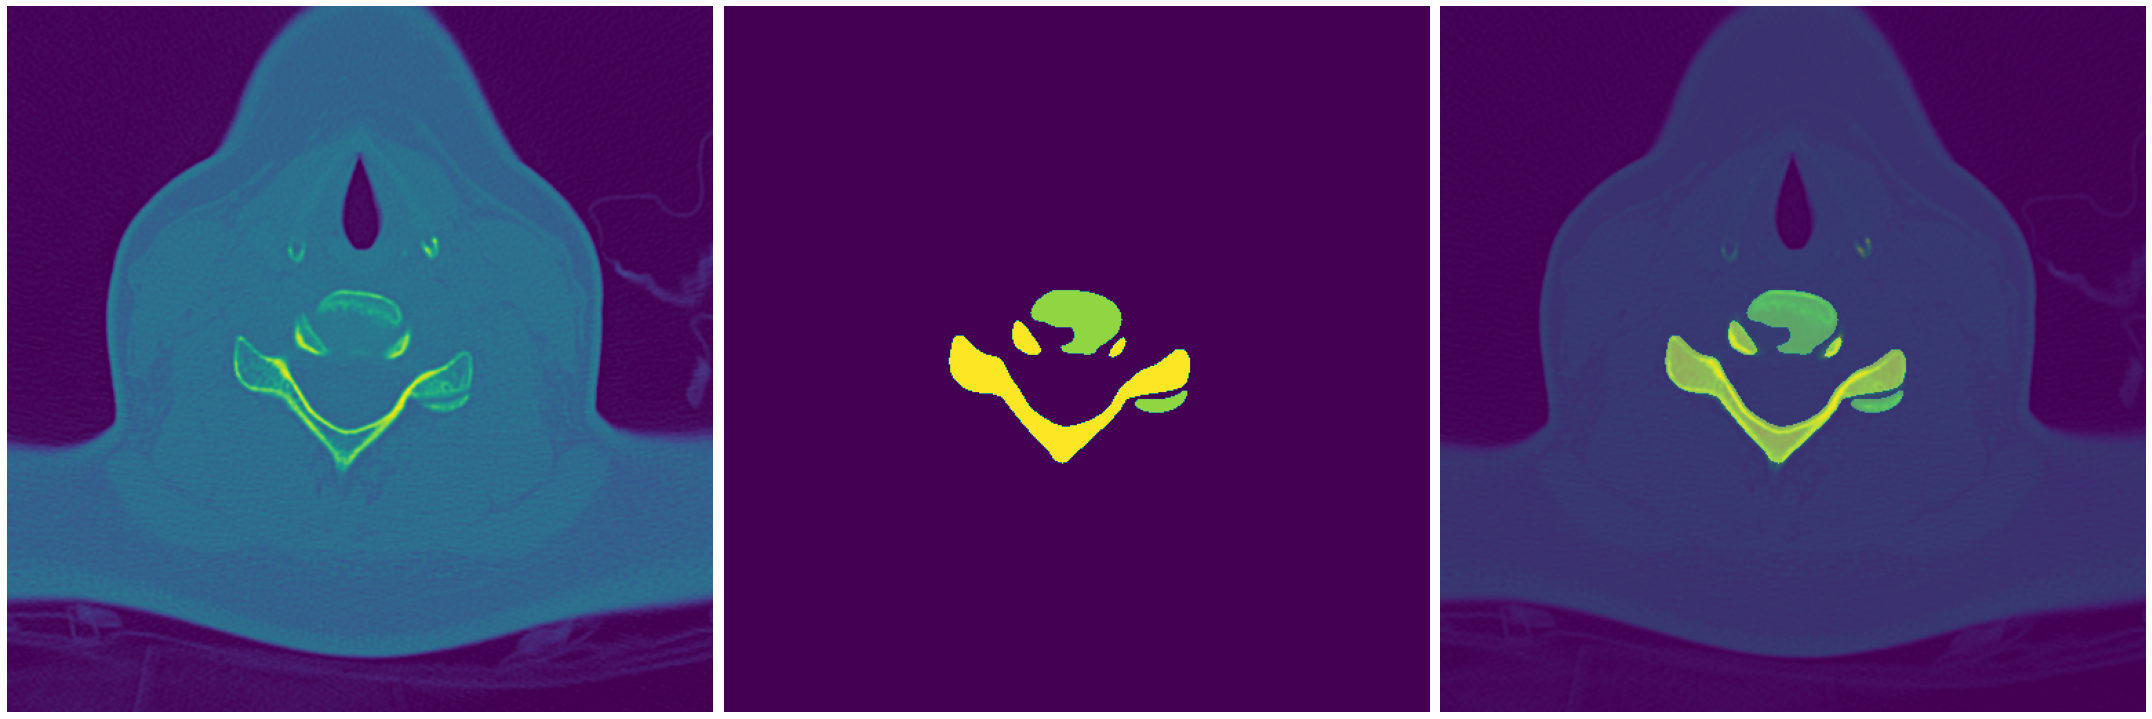

In [8]:
example_name = "1.2.826.0.1.3680043.780_147"
image_example = np.load(f"{datadir}/seg_25d_image/{example_name}.npy").transpose(2,0,1)
mask_example = np.load(f"{datadir}/seg_25d_mask/{example_name}.npy").transpose(2,0,1)
plt.figure(figsize=(30, 20))
plt.subplot(1, 3, 1); plt.imshow(image_example[1]); plt.axis('OFF');
plt.subplot(1, 3, 2); plt.imshow(mask_example[1]); plt.axis('OFF');
plt.subplot(1, 3, 3); plt.imshow(image_example[1]); plt.imshow(mask_example[1],alpha=0.5); plt.axis('OFF');
# plt.colorbar()
plt.tight_layout()
plt.show()

In [9]:
if CFG.device == 'TPU':
    import os
    VERSION = "1.7"
    CP_V = "36" if ENV == "colab" else "37"
    wheel = f"torch_xla-{VERSION}-cp{CP_V}-cp{CP_V}m-linux_x86_64.whl"
    url = f"https://storage.googleapis.com/tpu-pytorch/wheels/{wheel}"
    !pip3 -q install cloud-tpu-client==0.10 $url
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.train_bs = CFG.train_bs // CFG.nprocs
    device = xm.xla_device()
elif CFG.device == "GPU":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

# 日志记录函数
def init_logger(log_file=outputdir+'/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger(outputdir+f'/train{CFG.suffix}.log')

if CFG.device=='TPU' and CFG.nprocs==8:
    loginfo = xm.master_print
    cusprint = xm.master_print
else:
    loginfo = LOGGER.info
    cusprint = print

def get_result(result_df):
    preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
    labels = result_df[CFG.target_cols].values
    score, scores = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')


def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb


def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

# Dataset

In [11]:
# 构造 dataset类
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        image = np.load(f"{datadir}/seg_25d_image/{file_name}.npy") # 512 * 512 * 3
        mask = np.load(f"{datadir}/seg_25d_mask/{file_name}.npy") # 512 * 512 * 3

        # transform
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        image = image/255.0


        real_mask = np.zeros([CFG.num_classes, CFG.img_size, CFG.img_size])  # 8 * img_size * img_size
        for idx in range(CFG.num_classes):
            mask_bool = (mask[:,:,1] == (idx+1))
            real_mask[idx] = mask_bool 
        
        image = np.transpose(image, (2, 0, 1)) # 3 * img_size * img_size
        mask = np.transpose(mask, (2, 0, 1)) # 3 * img_size * img_size

        return torch.from_numpy(image), torch.from_numpy(real_mask), torch.from_numpy(mask)

In [12]:
# 图像AUG策略
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations

from albumentations.pytorch import ToTensorV2

def get_transforms(data):
    if data == 'train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                            min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)

    elif data == 'light_train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            # VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                # OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            # CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
            #              min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)

    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ])

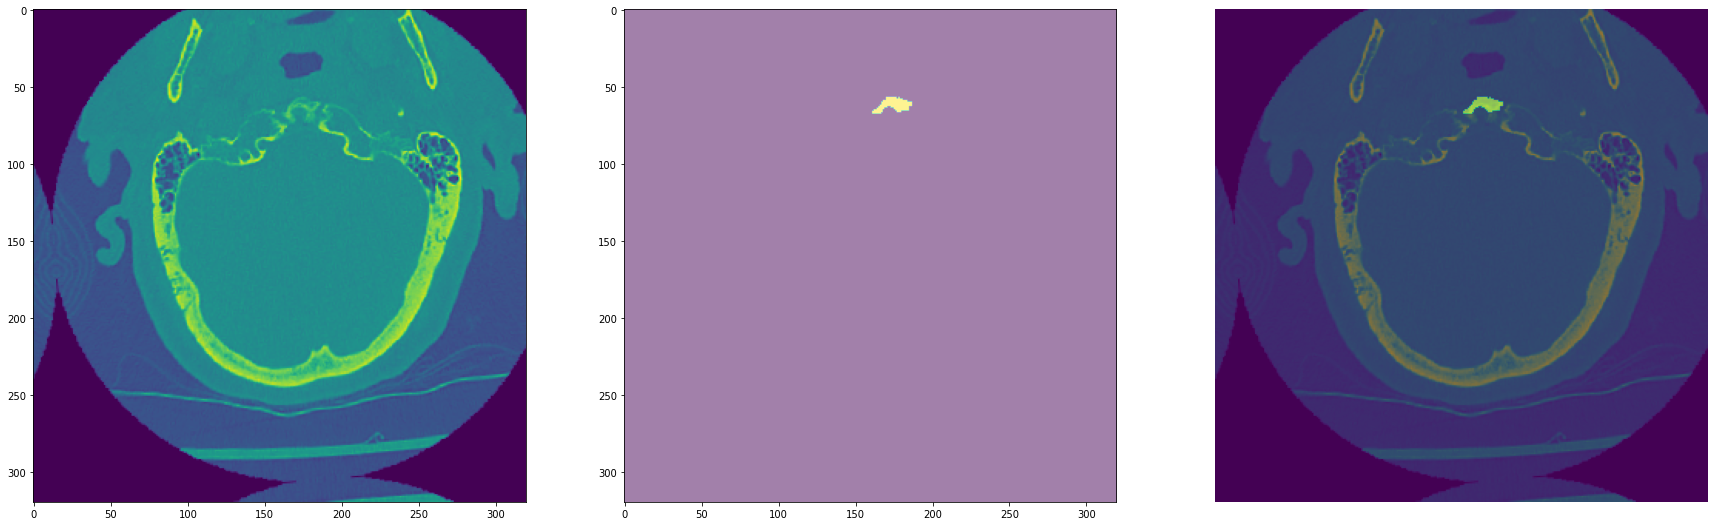

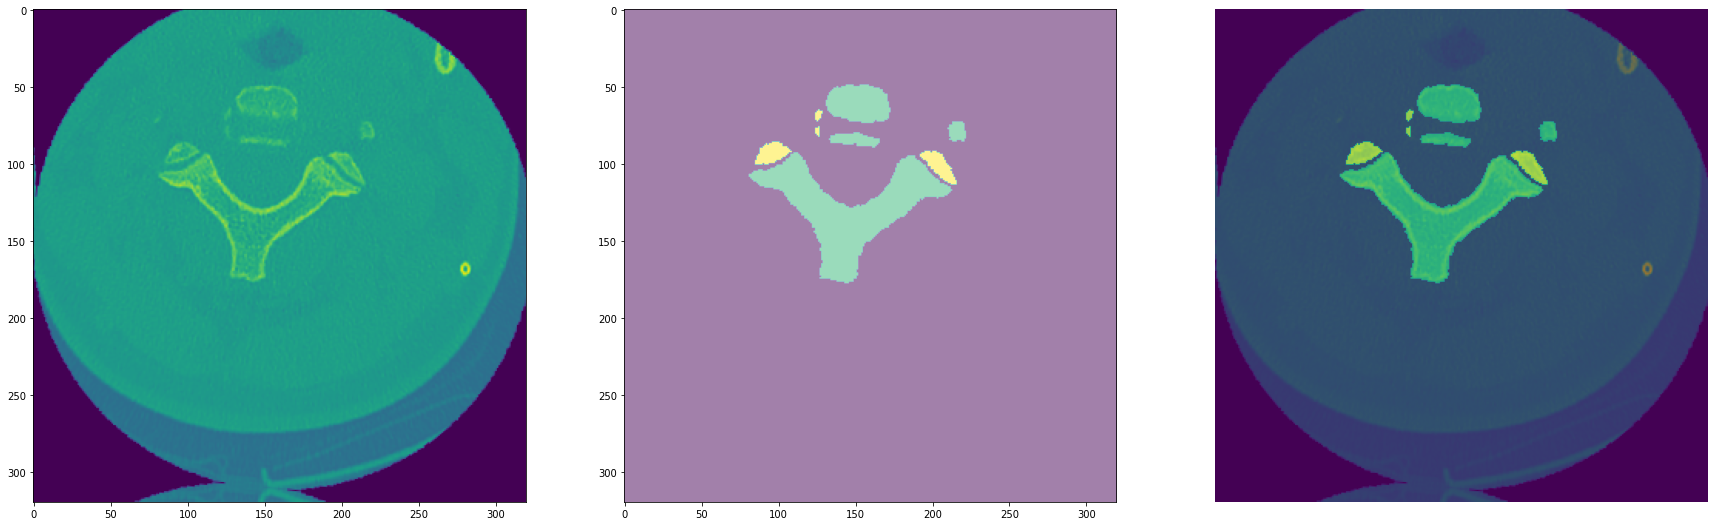

In [13]:
# 图像示例
from pylab import rcParams
dataset_show = TrainDataset(
    train_df, 
    get_transforms("light_train") # None, get_transforms("train")
    )
rcParams['figure.figsize'] = 30,20
for i in range(2):
    f, axarr = plt.subplots(1,3)
    idx = np.random.randint(0, len(dataset_show))
    img, mask, raw_mask = dataset_show[idx]
    # axarr[p].imshow(img) # transform=None
    axarr[0].imshow(img[1]); plt.axis('OFF');
    axarr[1].imshow(raw_mask[1]/255, alpha=0.5); plt.axis('OFF');
    axarr[2].imshow(img[1]); axarr[2].imshow(raw_mask[1]/255,alpha=0.5); plt.axis('OFF');

# Model

In [14]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.model_arch,    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [19]:
model=load_model("../../../../Data/Model_Optimization/2nd_model/RSNA2022RAWE/efficientnet-b0_109_fold0_epoch0.pth")
#model.eval()
model_int8 = torch.quantization.convert(model)

for elem in model_int8.values():
    for key, value in elem.items():
        print(value.dtype)

RuntimeError: Error(s) in loading state_dict for Unet:
	Missing key(s) in state_dict: "encoder._conv_stem.weight", "encoder._bn0.weight", "encoder._bn0.bias", "encoder._bn0.running_mean", "encoder._bn0.running_var", "encoder._blocks.0._depthwise_conv.weight", "encoder._blocks.0._bn1.weight", "encoder._blocks.0._bn1.bias", "encoder._blocks.0._bn1.running_mean", "encoder._blocks.0._bn1.running_var", "encoder._blocks.0._se_reduce.weight", "encoder._blocks.0._se_reduce.bias", "encoder._blocks.0._se_expand.weight", "encoder._blocks.0._se_expand.bias", "encoder._blocks.0._project_conv.weight", "encoder._blocks.0._bn2.weight", "encoder._blocks.0._bn2.bias", "encoder._blocks.0._bn2.running_mean", "encoder._blocks.0._bn2.running_var", "encoder._blocks.1._expand_conv.weight", "encoder._blocks.1._bn0.weight", "encoder._blocks.1._bn0.bias", "encoder._blocks.1._bn0.running_mean", "encoder._blocks.1._bn0.running_var", "encoder._blocks.1._depthwise_conv.weight", "encoder._blocks.1._bn1.weight", "encoder._blocks.1._bn1.bias", "encoder._blocks.1._bn1.running_mean", "encoder._blocks.1._bn1.running_var", "encoder._blocks.1._se_reduce.weight", "encoder._blocks.1._se_reduce.bias", "encoder._blocks.1._se_expand.weight", "encoder._blocks.1._se_expand.bias", "encoder._blocks.1._project_conv.weight", "encoder._blocks.1._bn2.weight", "encoder._blocks.1._bn2.bias", "encoder._blocks.1._bn2.running_mean", "encoder._blocks.1._bn2.running_var", "encoder._blocks.2._expand_conv.weight", "encoder._blocks.2._bn0.weight", "encoder._blocks.2._bn0.bias", "encoder._blocks.2._bn0.running_mean", "encoder._blocks.2._bn0.running_var", "encoder._blocks.2._depthwise_conv.weight", "encoder._blocks.2._bn1.weight", "encoder._blocks.2._bn1.bias", "encoder._blocks.2._bn1.running_mean", "encoder._blocks.2._bn1.running_var", "encoder._blocks.2._se_reduce.weight", "encoder._blocks.2._se_reduce.bias", "encoder._blocks.2._se_expand.weight", "encoder._blocks.2._se_expand.bias", "encoder._blocks.2._project_conv.weight", "encoder._blocks.2._bn2.weight", "encoder._blocks.2._bn2.bias", "encoder._blocks.2._bn2.running_mean", "encoder._blocks.2._bn2.running_var", "encoder._blocks.3._expand_conv.weight", "encoder._blocks.3._bn0.weight", "encoder._blocks.3._bn0.bias", "encoder._blocks.3._bn0.running_mean", "encoder._blocks.3._bn0.running_var", "encoder._blocks.3._depthwise_conv.weight", "encoder._blocks.3._bn1.weight", "encoder._blocks.3._bn1.bias", "encoder._blocks.3._bn1.running_mean", "encoder._blocks.3._bn1.running_var", "encoder._blocks.3._se_reduce.weight", "encoder._blocks.3._se_reduce.bias", "encoder._blocks.3._se_expand.weight", "encoder._blocks.3._se_expand.bias", "encoder._blocks.3._project_conv.weight", "encoder._blocks.3._bn2.weight", "encoder._blocks.3._bn2.bias", "encoder._blocks.3._bn2.running_mean", "encoder._blocks.3._bn2.running_var", "encoder._blocks.4._expand_conv.weight", "encoder._blocks.4._bn0.weight", "encoder._blocks.4._bn0.bias", "encoder._blocks.4._bn0.running_mean", "encoder._blocks.4._bn0.running_var", "encoder._blocks.4._depthwise_conv.weight", "encoder._blocks.4._bn1.weight", "encoder._blocks.4._bn1.bias", "encoder._blocks.4._bn1.running_mean", "encoder._blocks.4._bn1.running_var", "encoder._blocks.4._se_reduce.weight", "encoder._blocks.4._se_reduce.bias", "encoder._blocks.4._se_expand.weight", "encoder._blocks.4._se_expand.bias", "encoder._blocks.4._project_conv.weight", "encoder._blocks.4._bn2.weight", "encoder._blocks.4._bn2.bias", "encoder._blocks.4._bn2.running_mean", "encoder._blocks.4._bn2.running_var", "encoder._blocks.5._expand_conv.weight", "encoder._blocks.5._bn0.weight", "encoder._blocks.5._bn0.bias", "encoder._blocks.5._bn0.running_mean", "encoder._blocks.5._bn0.running_var", "encoder._blocks.5._depthwise_conv.weight", "encoder._blocks.5._bn1.weight", "encoder._blocks.5._bn1.bias", "encoder._blocks.5._bn1.running_mean", "encoder._blocks.5._bn1.running_var", "encoder._blocks.5._se_reduce.weight", "encoder._blocks.5._se_reduce.bias", "encoder._blocks.5._se_expand.weight", "encoder._blocks.5._se_expand.bias", "encoder._blocks.5._project_conv.weight", "encoder._blocks.5._bn2.weight", "encoder._blocks.5._bn2.bias", "encoder._blocks.5._bn2.running_mean", "encoder._blocks.5._bn2.running_var", "encoder._blocks.6._expand_conv.weight", "encoder._blocks.6._bn0.weight", "encoder._blocks.6._bn0.bias", "encoder._blocks.6._bn0.running_mean", "encoder._blocks.6._bn0.running_var", "encoder._blocks.6._depthwise_conv.weight", "encoder._blocks.6._bn1.weight", "encoder._blocks.6._bn1.bias", "encoder._blocks.6._bn1.running_mean", "encoder._blocks.6._bn1.running_var", "encoder._blocks.6._se_reduce.weight", "encoder._blocks.6._se_reduce.bias", "encoder._blocks.6._se_expand.weight", "encoder._blocks.6._se_expand.bias", "encoder._blocks.6._project_conv.weight", "encoder._blocks.6._bn2.weight", "encoder._blocks.6._bn2.bias", "encoder._blocks.6._bn2.running_mean", "encoder._blocks.6._bn2.running_var", "encoder._blocks.7._expand_conv.weight", "encoder._blocks.7._bn0.weight", "encoder._blocks.7._bn0.bias", "encoder._blocks.7._bn0.running_mean", "encoder._blocks.7._bn0.running_var", "encoder._blocks.7._depthwise_conv.weight", "encoder._blocks.7._bn1.weight", "encoder._blocks.7._bn1.bias", "encoder._blocks.7._bn1.running_mean", "encoder._blocks.7._bn1.running_var", "encoder._blocks.7._se_reduce.weight", "encoder._blocks.7._se_reduce.bias", "encoder._blocks.7._se_expand.weight", "encoder._blocks.7._se_expand.bias", "encoder._blocks.7._project_conv.weight", "encoder._blocks.7._bn2.weight", "encoder._blocks.7._bn2.bias", "encoder._blocks.7._bn2.running_mean", "encoder._blocks.7._bn2.running_var", "encoder._blocks.8._expand_conv.weight", "encoder._blocks.8._bn0.weight", "encoder._blocks.8._bn0.bias", "encoder._blocks.8._bn0.running_mean", "encoder._blocks.8._bn0.running_var", "encoder._blocks.8._depthwise_conv.weight", "encoder._blocks.8._bn1.weight", "encoder._blocks.8._bn1.bias", "encoder._blocks.8._bn1.running_mean", "encoder._blocks.8._bn1.running_var", "encoder._blocks.8._se_reduce.weight", "encoder._blocks.8._se_reduce.bias", "encoder._blocks.8._se_expand.weight", "encoder._blocks.8._se_expand.bias", "encoder._blocks.8._project_conv.weight", "encoder._blocks.8._bn2.weight", "encoder._blocks.8._bn2.bias", "encoder._blocks.8._bn2.running_mean", "encoder._blocks.8._bn2.running_var", "encoder._blocks.9._expand_conv.weight", "encoder._blocks.9._bn0.weight", "encoder._blocks.9._bn0.bias", "encoder._blocks.9._bn0.running_mean", "encoder._blocks.9._bn0.running_var", "encoder._blocks.9._depthwise_conv.weight", "encoder._blocks.9._bn1.weight", "encoder._blocks.9._bn1.bias", "encoder._blocks.9._bn1.running_mean", "encoder._blocks.9._bn1.running_var", "encoder._blocks.9._se_reduce.weight", "encoder._blocks.9._se_reduce.bias", "encoder._blocks.9._se_expand.weight", "encoder._blocks.9._se_expand.bias", "encoder._blocks.9._project_conv.weight", "encoder._blocks.9._bn2.weight", "encoder._blocks.9._bn2.bias", "encoder._blocks.9._bn2.running_mean", "encoder._blocks.9._bn2.running_var", "encoder._blocks.10._expand_conv.weight", "encoder._blocks.10._bn0.weight", "encoder._blocks.10._bn0.bias", "encoder._blocks.10._bn0.running_mean", "encoder._blocks.10._bn0.running_var", "encoder._blocks.10._depthwise_conv.weight", "encoder._blocks.10._bn1.weight", "encoder._blocks.10._bn1.bias", "encoder._blocks.10._bn1.running_mean", "encoder._blocks.10._bn1.running_var", "encoder._blocks.10._se_reduce.weight", "encoder._blocks.10._se_reduce.bias", "encoder._blocks.10._se_expand.weight", "encoder._blocks.10._se_expand.bias", "encoder._blocks.10._project_conv.weight", "encoder._blocks.10._bn2.weight", "encoder._blocks.10._bn2.bias", "encoder._blocks.10._bn2.running_mean", "encoder._blocks.10._bn2.running_var", "encoder._blocks.11._expand_conv.weight", "encoder._blocks.11._bn0.weight", "encoder._blocks.11._bn0.bias", "encoder._blocks.11._bn0.running_mean", "encoder._blocks.11._bn0.running_var", "encoder._blocks.11._depthwise_conv.weight", "encoder._blocks.11._bn1.weight", "encoder._blocks.11._bn1.bias", "encoder._blocks.11._bn1.running_mean", "encoder._blocks.11._bn1.running_var", "encoder._blocks.11._se_reduce.weight", "encoder._blocks.11._se_reduce.bias", "encoder._blocks.11._se_expand.weight", "encoder._blocks.11._se_expand.bias", "encoder._blocks.11._project_conv.weight", "encoder._blocks.11._bn2.weight", "encoder._blocks.11._bn2.bias", "encoder._blocks.11._bn2.running_mean", "encoder._blocks.11._bn2.running_var", "encoder._blocks.12._expand_conv.weight", "encoder._blocks.12._bn0.weight", "encoder._blocks.12._bn0.bias", "encoder._blocks.12._bn0.running_mean", "encoder._blocks.12._bn0.running_var", "encoder._blocks.12._depthwise_conv.weight", "encoder._blocks.12._bn1.weight", "encoder._blocks.12._bn1.bias", "encoder._blocks.12._bn1.running_mean", "encoder._blocks.12._bn1.running_var", "encoder._blocks.12._se_reduce.weight", "encoder._blocks.12._se_reduce.bias", "encoder._blocks.12._se_expand.weight", "encoder._blocks.12._se_expand.bias", "encoder._blocks.12._project_conv.weight", "encoder._blocks.12._bn2.weight", "encoder._blocks.12._bn2.bias", "encoder._blocks.12._bn2.running_mean", "encoder._blocks.12._bn2.running_var", "encoder._blocks.13._expand_conv.weight", "encoder._blocks.13._bn0.weight", "encoder._blocks.13._bn0.bias", "encoder._blocks.13._bn0.running_mean", "encoder._blocks.13._bn0.running_var", "encoder._blocks.13._depthwise_conv.weight", "encoder._blocks.13._bn1.weight", "encoder._blocks.13._bn1.bias", "encoder._blocks.13._bn1.running_mean", "encoder._blocks.13._bn1.running_var", "encoder._blocks.13._se_reduce.weight", "encoder._blocks.13._se_reduce.bias", "encoder._blocks.13._se_expand.weight", "encoder._blocks.13._se_expand.bias", "encoder._blocks.13._project_conv.weight", "encoder._blocks.13._bn2.weight", "encoder._blocks.13._bn2.bias", "encoder._blocks.13._bn2.running_mean", "encoder._blocks.13._bn2.running_var", "encoder._blocks.14._expand_conv.weight", "encoder._blocks.14._bn0.weight", "encoder._blocks.14._bn0.bias", "encoder._blocks.14._bn0.running_mean", "encoder._blocks.14._bn0.running_var", "encoder._blocks.14._depthwise_conv.weight", "encoder._blocks.14._bn1.weight", "encoder._blocks.14._bn1.bias", "encoder._blocks.14._bn1.running_mean", "encoder._blocks.14._bn1.running_var", "encoder._blocks.14._se_reduce.weight", "encoder._blocks.14._se_reduce.bias", "encoder._blocks.14._se_expand.weight", "encoder._blocks.14._se_expand.bias", "encoder._blocks.14._project_conv.weight", "encoder._blocks.14._bn2.weight", "encoder._blocks.14._bn2.bias", "encoder._blocks.14._bn2.running_mean", "encoder._blocks.14._bn2.running_var", "encoder._blocks.15._expand_conv.weight", "encoder._blocks.15._bn0.weight", "encoder._blocks.15._bn0.bias", "encoder._blocks.15._bn0.running_mean", "encoder._blocks.15._bn0.running_var", "encoder._blocks.15._depthwise_conv.weight", "encoder._blocks.15._bn1.weight", "encoder._blocks.15._bn1.bias", "encoder._blocks.15._bn1.running_mean", "encoder._blocks.15._bn1.running_var", "encoder._blocks.15._se_reduce.weight", "encoder._blocks.15._se_reduce.bias", "encoder._blocks.15._se_expand.weight", "encoder._blocks.15._se_expand.bias", "encoder._blocks.15._project_conv.weight", "encoder._blocks.15._bn2.weight", "encoder._blocks.15._bn2.bias", "encoder._blocks.15._bn2.running_mean", "encoder._blocks.15._bn2.running_var", "encoder._conv_head.weight", "encoder._bn1.weight", "encoder._bn1.bias", "encoder._bn1.running_mean", "encoder._bn1.running_var", "decoder.blocks.0.conv1.0.weight", "decoder.blocks.0.conv1.1.weight", "decoder.blocks.0.conv1.1.bias", "decoder.blocks.0.conv1.1.running_mean", "decoder.blocks.0.conv1.1.running_var", "decoder.blocks.0.conv2.0.weight", "decoder.blocks.0.conv2.1.weight", "decoder.blocks.0.conv2.1.bias", "decoder.blocks.0.conv2.1.running_mean", "decoder.blocks.0.conv2.1.running_var", "decoder.blocks.1.conv1.0.weight", "decoder.blocks.1.conv1.1.weight", "decoder.blocks.1.conv1.1.bias", "decoder.blocks.1.conv1.1.running_mean", "decoder.blocks.1.conv1.1.running_var", "decoder.blocks.1.conv2.0.weight", "decoder.blocks.1.conv2.1.weight", "decoder.blocks.1.conv2.1.bias", "decoder.blocks.1.conv2.1.running_mean", "decoder.blocks.1.conv2.1.running_var", "decoder.blocks.2.conv1.0.weight", "decoder.blocks.2.conv1.1.weight", "decoder.blocks.2.conv1.1.bias", "decoder.blocks.2.conv1.1.running_mean", "decoder.blocks.2.conv1.1.running_var", "decoder.blocks.2.conv2.0.weight", "decoder.blocks.2.conv2.1.weight", "decoder.blocks.2.conv2.1.bias", "decoder.blocks.2.conv2.1.running_mean", "decoder.blocks.2.conv2.1.running_var", "decoder.blocks.3.conv1.0.weight", "decoder.blocks.3.conv1.1.weight", "decoder.blocks.3.conv1.1.bias", "decoder.blocks.3.conv1.1.running_mean", "decoder.blocks.3.conv1.1.running_var", "decoder.blocks.3.conv2.0.weight", "decoder.blocks.3.conv2.1.weight", "decoder.blocks.3.conv2.1.bias", "decoder.blocks.3.conv2.1.running_mean", "decoder.blocks.3.conv2.1.running_var", "decoder.blocks.4.conv1.0.weight", "decoder.blocks.4.conv1.1.weight", "decoder.blocks.4.conv1.1.bias", "decoder.blocks.4.conv1.1.running_mean", "decoder.blocks.4.conv1.1.running_var", "decoder.blocks.4.conv2.0.weight", "decoder.blocks.4.conv2.1.weight", "decoder.blocks.4.conv2.1.bias", "decoder.blocks.4.conv2.1.running_mean", "decoder.blocks.4.conv2.1.running_var", "segmentation_head.0.weight", "segmentation_head.0.bias". 
	Unexpected key(s) in state_dict: "model". 

In [12]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.int8)
    y_pred = (y_pred>thr).to(torch.int8)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice


In [13]:
def train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    
    model.train()
    start = end = time.time()
    for step, (images, masks, raw_mask) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.int)
        masks = masks.to(device, dtype=torch.int)
        batch_size = images.size(0)

        if CFG.device == 'GPU':
            with autocast(enabled=True):
                y_preds = model(images)
                loss = criterion(y_preds, masks)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        elif CFG.device == 'TPU':
            y_preds = model(images)
            loss = criterion(y_preds, masks)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            cusprint('Epoch: [{0}][{1}/{2}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                'Grad: {grad_norm:.4f}  '
                'LR: {lr:.7f}  '
                .format(
                epoch, step, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(train_loader)),
                grad_norm=grad_norm,
                lr=optimizer.param_groups[0]["lr"],
                ))

    return losses.avg, optimizer.param_groups[0]["lr"]

In [14]:
def valid_one_epoch(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    start = end = time.time()
    val_scores = []
    for step, (images, masks, raw_mask) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.int)
        masks = masks.to(device, dtype=torch.int)
        batch_size = images.size(0)
        # compute loss
        with torch.no_grad():
            y_pred = model(images)
        loss = criterion(y_pred, masks)
        losses.update(loss.item(), batch_size)

        # record accuracy
        y_pred = y_pred.sigmoid() ####
        # y_pred = y_pred.sigmoid().to('cpu').numpy()
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice])

        if CFG.accum_iter > 1:
            loss = loss / CFG.accum_iter
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            cusprint('EVAL: [{0}/{1}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                step, len(valid_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(valid_loader)),
                ))

    val_scores = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    return losses.avg, val_scores

# loss & optimizer & scheduler

In [15]:
# 自定义逐渐升温调度器
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

# Training

In [16]:
# 训练函数
def train_loop(df, fold):
    loginfo(f"========== fold: {fold} training ==========")
    # ====================================================
    # loader 
    # ====================================================
    train_folds = train_df[train_df["fold"] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df["fold"] == fold].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='light_train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))
    if CFG.device == 'GPU':
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True, num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.train_bs, sampler=train_sampler, drop_last=True, num_workers=CFG.num_workers)
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CFG.valid_bs, sampler=valid_sampler, drop_last=False, num_workers=CFG.num_workers)

    # ====================================================
    # model & optimizer & scheduler & loss 
    # ====================================================
    model = build_model()
    
    model = torch.quantization.convert(model, inplace=False)
    model.eval()
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 5e-3)
    model.qconfig = torch.ao.quantization.get_default_qat_qconfig('fbgemm')

    # optimizer
    if CFG.optimizer == "AdamW":
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            optimizer = AdamW(model.parameters(), lr=CFG.lr/CFG.warmup_factor, weight_decay=CFG.weight_decay) 
        else:
            optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)  
    # scheduler
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)

    if CFG.scheduler_warmup=="GradualWarmupSchedulerV3":
        scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)

    # loss
    def criterion(y_pred, y_true):
        return 0.5*BCELoss(y_pred, y_true) + 0.5*DiceLoss(y_pred, y_true)

    # ====================================================
    # loop 
    # ====================================================

    valid_acc_max=0
    valid_acc_max_cnt=0
    for epoch in range(CFG.epochs):
        loginfo(f"***** Epoch {epoch} *****")
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            pass
            # loginfo(f"schwarmup_last_epoch:{scheduler_warmup.last_epoch}, schwarmup_lr:{scheduler_warmup.get_last_lr()[0]}")
        if CFG.scheduler=='CosineAnnealingLR':
            loginfo(f"scheduler_last_epoch:{scheduler.last_epoch}, scheduler_lr:{scheduler.get_last_lr()[0]}")
        loginfo(f"optimizer_lr:{optimizer.param_groups[0]['lr']}")
                
        start_time = time.time() # 记录当前时间

        # train
        if CFG.device == 'TPU' and CFG.nprocs == 8:
            para_train_loader = pl.ParallelLoader(train_loader, [device])
            avg_loss, cur_lr = train_one_epoch(para_train_loader.per_device_loader(device), model, criterion, optimizer, epoch, scheduler, device)
        else:
            avg_loss, cur_lr = train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # valid
        if CFG.device == 'TPU' and CFG.nprocs == 8:
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            avg_val_loss, valid_scores = valid_one_epoch(para_valid_loader.per_device_loader(device), model, criterion, device)
            preds = idist.all_gather(torch.tensor(preds)).to('cpu').numpy()
            valid_labels = idist.all_gather(torch.tensor(valid_labels)).to('cpu').numpy()
        else:
            avg_val_loss, valid_scores = valid_one_epoch(valid_loader, model, criterion, device)

        # scoring
        elapsed = time.time() - start_time
        
        # print("valid_scores:", valid_scores, type(valid_scores))
        valid_scores = valid_scores[0]
        loginfo(f'Epoch {epoch} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        loginfo(f'Epoch {epoch} - Score: {valid_scores:.4f}')
        
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            scheduler_warmup.step()
        elif CFG.scheduler == "ReduceLROnPlateau":
            scheduler.step(avg_val_loss)
        elif CFG.scheduler in ["CosineAnnealingLR", "CosineAnnealingWarmRestarts"]:
            scheduler.step()

        if CFG.device == 'GPU':
            torch.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
        elif CFG.device == 'TPU':
            xm.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')

        # early stopping 
        if valid_scores > valid_acc_max:
            valid_acc_max = valid_scores
            valid_acc_max_cnt=0
            best_acc_epoch = epoch
        else:
            valid_acc_max_cnt+=1


        if valid_acc_max_cnt >= CFG.n_early_stopping:
            if CFG.device == 'GPU':
                torch.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            elif CFG.device == 'TPU':
                xm.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            print("early_stopping")
            break
        
        if CFG.device == 'GPU':
            torch.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
        elif CFG.device == 'TPU':
            xm.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')

In [17]:
def main():
    for fold in range(CFG.fold_num):
        if fold in CFG.fold_list:
            train_loop(train_df, fold)

# Main

In [18]:
if __name__ == '__main__':
    print(CFG.suffix)
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            #torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        main()

========== fold: 0 training ==========


109


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /home/apaddo/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

***** Epoch 0 *****
scheduler_last_epoch:0, scheduler_lr:0.0005
optimizer_lr:0.0005


Epoch: [0][0/1486] Data 1.006 (1.006) Elapsed 0m 20s (remain 518m 29s) Loss: 0.8615(0.8615) Grad: 29606.8945  LR: 0.0005000  
Epoch: [0][100/1486] Data 0.000 (0.010) Elapsed 0m 49s (remain 11m 12s) Loss: 0.4404(0.6197) Grad: 5265.1182  LR: 0.0005000  
Epoch: [0][200/1486] Data 0.000 (0.005) Elapsed 1m 17s (remain 8m 17s) Loss: 0.3835(0.5266) Grad: 2885.8977  LR: 0.0005000  
Epoch: [0][300/1486] Data 0.001 (0.004) Elapsed 1m 46s (remain 6m 58s) Loss: 0.4032(0.4838) Grad: 8440.0781  LR: 0.0005000  
Epoch: [0][400/1486] Data 0.000 (0.003) Elapsed 2m 14s (remain 6m 2s) Loss: 0.4014(0.4573) Grad: 6250.9556  LR: 0.0005000  
Epoch: [0][500/1486] Data 0.000 (0.002) Elapsed 2m 41s (remain 5m 18s) Loss: 0.4202(0.4409) Grad: 4698.2217  LR: 0.0005000  
Epoch: [0][600/1486] Data 0.000 (0.002) Elapsed 3m 9s (remain 4m 39s) Loss: 0.3006(0.4256) Grad: 9983.4990  LR: 0.0005000  
Epoch: [0][700/1486] Data 0.000 (0.002) Elapsed 3m 37s (remain 4m 3s) Loss: 0.3414(0.4134) Grad: 9230.1943  LR: 0.0005000  
E

Epoch 0 - avg_train_loss: 0.3356  avg_val_loss: 0.0687  time: 582s
Epoch 0 - Score: 0.8282
/home/apaddo/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
***** Epoch 1 *****
scheduler_last_epoch:0, scheduler_lr:0.0005
optimizer_lr:0.0005


Epoch: [1][0/1486] Data 1.720 (1.720) Elapsed 0m 2s (remain 50m 3s) Loss: 0.2708(0.2708) Grad: 102884.8359  LR: 0.0005000  
Epoch: [1][100/1486] Data 0.000 (0.017) Elapsed 0m 29s (remain 6m 46s) Loss: 0.2199(0.2124) Grad: 32730.1836  LR: 0.0005000  
Epoch: [1][200/1486] Data 0.000 (0.009) Elapsed 0m 57s (remain 6m 4s) Loss: 0.2170(0.2038) Grad: 18721.1270  LR: 0.0005000  
Epoch: [1][300/1486] Data 0.000 (0.006) Elapsed 1m 23s (remain 5m 27s) Loss: 0.1840(0.1980) Grad: 33142.4727  LR: 0.0005000  
Epoch: [1][400/1486] Data 0.000 (0.005) Elapsed 1m 50s (remain 5m 0s) Loss: 0.0882(0.1931) Grad: 42001.3672  LR: 0.0005000  
Epoch: [1][500/1486] Data 0.000 (0.004) Elapsed 2m 19s (remain 4m 33s) Loss: 0.1406(0.1883) Grad: 16598.2949  LR: 0.0005000  
Epoch: [1][600/1486] Data 0.000 (0.003) Elapsed 2m 46s (remain 4m 4s) Loss: 0.1909(0.1859) Grad: 87116.2578  LR: 0.0005000  
Epoch: [1][700/1486] Data 0.000 (0.003) Elapsed 3m 13s (remain 3m 36s) Loss: 0.2861(0.1837) Grad: 79453.6172  LR: 0.0005000

Epoch 1 - avg_train_loss: 0.1653  avg_val_loss: 0.0548  time: 530s
Epoch 1 - Score: 0.9059


EVAL: [183/184] Data 0.129 (0.440) Elapsed 2m 5s (remain 0m 0s) Loss: 0.0276(0.0548) 


***** Epoch 2 *****
scheduler_last_epoch:1, scheduler_lr:0.0004927499834478
optimizer_lr:0.0004927499834478


Epoch: [2][0/1486] Data 1.060 (1.060) Elapsed 0m 1s (remain 32m 45s) Loss: 0.2487(0.2487) Grad: 41098.2266  LR: 0.0004927  
Epoch: [2][100/1486] Data 0.000 (0.011) Elapsed 0m 29s (remain 6m 41s) Loss: 0.2618(0.1414) Grad: 31660.1094  LR: 0.0004927  
Epoch: [2][200/1486] Data 0.000 (0.006) Elapsed 0m 57s (remain 6m 5s) Loss: 0.1076(0.1340) Grad: 37715.9766  LR: 0.0004927  
Epoch: [2][300/1486] Data 0.000 (0.004) Elapsed 1m 25s (remain 5m 35s) Loss: 0.1602(0.1332) Grad: 53600.1641  LR: 0.0004927  
Epoch: [2][400/1486] Data 0.000 (0.003) Elapsed 1m 53s (remain 5m 6s) Loss: 0.0580(0.1309) Grad: 33315.1562  LR: 0.0004927  
Epoch: [2][500/1486] Data 0.000 (0.002) Elapsed 2m 21s (remain 4m 37s) Loss: 0.1247(0.1296) Grad: 30711.2793  LR: 0.0004927  
Epoch: [2][600/1486] Data 0.000 (0.002) Elapsed 2m 49s (remain 4m 9s) Loss: 0.1363(0.1273) Grad: 70361.7734  LR: 0.0004927  
Epoch: [2][700/1486] Data 0.000 (0.002) Elapsed 3m 17s (remain 3m 40s) Loss: 0.0384(0.1257) Grad: 24398.9043  LR: 0.0004927

Epoch 2 - avg_train_loss: 0.1265  avg_val_loss: 0.0524  time: 536s
Epoch 2 - Score: 0.9215
***** Epoch 3 *****
scheduler_last_epoch:2, scheduler_lr:0.0004714212784004759
optimizer_lr:0.0004714212784004759


Epoch: [3][0/1486] Data 1.262 (1.262) Elapsed 0m 1s (remain 37m 47s) Loss: 0.0825(0.0825) Grad: 55250.8047  LR: 0.0004714  
Epoch: [3][100/1486] Data 0.000 (0.015) Elapsed 0m 29s (remain 6m 50s) Loss: 0.1284(0.1085) Grad: 52424.2695  LR: 0.0004714  
Epoch: [3][200/1486] Data 0.000 (0.007) Elapsed 0m 56s (remain 6m 2s) Loss: 0.0778(0.1044) Grad: 38323.3633  LR: 0.0004714  
Epoch: [3][300/1486] Data 0.000 (0.005) Elapsed 1m 24s (remain 5m 32s) Loss: 0.1225(0.1010) Grad: 30190.4258  LR: 0.0004714  
Epoch: [3][400/1486] Data 0.000 (0.004) Elapsed 1m 51s (remain 5m 2s) Loss: 0.0982(0.0986) Grad: 44143.1328  LR: 0.0004714  
Epoch: [3][500/1486] Data 0.000 (0.003) Elapsed 2m 18s (remain 4m 33s) Loss: 0.0999(0.0983) Grad: 35540.2734  LR: 0.0004714  
Epoch: [3][600/1486] Data 0.000 (0.003) Elapsed 2m 46s (remain 4m 4s) Loss: 0.0512(0.0978) Grad: 22236.2305  LR: 0.0004714  
Epoch: [3][700/1486] Data 0.000 (0.003) Elapsed 3m 14s (remain 3m 37s) Loss: 0.0671(0.0978) Grad: 19105.3438  LR: 0.0004714

Epoch 3 - avg_train_loss: 0.0922  avg_val_loss: 0.0418  time: 537s
Epoch 3 - Score: 0.9343
***** Epoch 4 *****
scheduler_last_epoch:3, scheduler_lr:0.00043725343166868975
optimizer_lr:0.00043725343166868975


Epoch: [4][0/1486] Data 1.672 (1.672) Elapsed 0m 1s (remain 48m 7s) Loss: 0.0505(0.0505) Grad: 20459.1758  LR: 0.0004373  
Epoch: [4][100/1486] Data 0.000 (0.017) Elapsed 0m 29s (remain 6m 50s) Loss: 0.1010(0.0859) Grad: 13950.6338  LR: 0.0004373  
Epoch: [4][200/1486] Data 0.000 (0.009) Elapsed 0m 58s (remain 6m 13s) Loss: 0.1271(0.0835) Grad: 59927.0977  LR: 0.0004373  
Epoch: [4][300/1486] Data 0.000 (0.006) Elapsed 1m 26s (remain 5m 39s) Loss: 0.1198(0.0843) Grad: 15902.5332  LR: 0.0004373  
Epoch: [4][400/1486] Data 0.000 (0.005) Elapsed 1m 54s (remain 5m 9s) Loss: 0.1876(0.0842) Grad: 14479.4365  LR: 0.0004373  
Epoch: [4][500/1486] Data 0.000 (0.004) Elapsed 2m 22s (remain 4m 39s) Loss: 0.0726(0.0832) Grad: 79551.0156  LR: 0.0004373  
Epoch: [4][600/1486] Data 0.000 (0.003) Elapsed 2m 50s (remain 4m 11s) Loss: 0.0332(0.0837) Grad: 10626.4297  LR: 0.0004373  
Epoch: [4][700/1486] Data 0.000 (0.003) Elapsed 3m 18s (remain 3m 42s) Loss: 0.0613(0.0842) Grad: 18275.8711  LR: 0.000437

Epoch 4 - avg_train_loss: 0.0828  avg_val_loss: 0.0383  time: 535s
Epoch 4 - Score: 0.9357
***** Epoch 5 *****
scheduler_last_epoch:4, scheduler_lr:0.00039223215430942343
optimizer_lr:0.00039223215430942343


Epoch: [5][0/1486] Data 1.204 (1.204) Elapsed 0m 1s (remain 36m 34s) Loss: 0.0624(0.0624) Grad: 42931.8945  LR: 0.0003922  
Epoch: [5][100/1486] Data 0.000 (0.012) Elapsed 0m 27s (remain 6m 16s) Loss: 0.1001(0.0772) Grad: 15611.0146  LR: 0.0003922  
Epoch: [5][200/1486] Data 0.000 (0.006) Elapsed 0m 52s (remain 5m 36s) Loss: 0.0645(0.0756) Grad: 42078.0156  LR: 0.0003922  
Epoch: [5][300/1486] Data 0.000 (0.004) Elapsed 1m 19s (remain 5m 11s) Loss: 0.0257(0.0791) Grad: 6805.3809  LR: 0.0003922  
Epoch: [5][400/1486] Data 0.000 (0.003) Elapsed 1m 45s (remain 4m 44s) Loss: 0.0317(0.0799) Grad: 12842.6553  LR: 0.0003922  
Epoch: [5][500/1486] Data 0.000 (0.003) Elapsed 2m 11s (remain 4m 18s) Loss: 0.0511(0.0786) Grad: 10246.3828  LR: 0.0003922  
Epoch: [5][600/1486] Data 0.000 (0.002) Elapsed 2m 37s (remain 3m 52s) Loss: 0.0432(0.0765) Grad: 17285.8613  LR: 0.0003922  
Epoch: [5][700/1486] Data 0.000 (0.002) Elapsed 3m 4s (remain 3m 26s) Loss: 0.0476(0.0763) Grad: 7053.8989  LR: 0.0003922

Epoch 5 - avg_train_loss: 0.0756  avg_val_loss: 0.0367  time: 485s
Epoch 5 - Score: 0.9506
***** Epoch 6 *****
scheduler_last_epoch:5, scheduler_lr:0.0003389739193171126
optimizer_lr:0.0003389739193171126


Epoch: [6][0/1486] Data 1.000 (1.000) Elapsed 0m 1s (remain 30m 51s) Loss: 0.0525(0.0525) Grad: 7143.4478  LR: 0.0003390  
Epoch: [6][100/1486] Data 0.000 (0.011) Elapsed 0m 28s (remain 6m 25s) Loss: 0.0314(0.0749) Grad: 5064.4785  LR: 0.0003390  
Epoch: [6][200/1486] Data 0.000 (0.005) Elapsed 0m 54s (remain 5m 48s) Loss: 0.0413(0.0717) Grad: 5901.6240  LR: 0.0003390  
Epoch: [6][300/1486] Data 0.000 (0.004) Elapsed 1m 21s (remain 5m 19s) Loss: 0.0293(0.0711) Grad: 13857.6992  LR: 0.0003390  
Epoch: [6][400/1486] Data 0.000 (0.003) Elapsed 1m 47s (remain 4m 51s) Loss: 0.0692(0.0708) Grad: 29949.7383  LR: 0.0003390  
Epoch: [6][500/1486] Data 0.000 (0.002) Elapsed 2m 14s (remain 4m 23s) Loss: 0.0541(0.0706) Grad: 14619.8359  LR: 0.0003390  
Epoch: [6][600/1486] Data 0.000 (0.002) Elapsed 2m 40s (remain 3m 56s) Loss: 0.0415(0.0702) Grad: 12524.9258  LR: 0.0003390  
Epoch: [6][700/1486] Data 0.000 (0.002) Elapsed 3m 7s (remain 3m 30s) Loss: 0.0397(0.0707) Grad: 4919.2065  LR: 0.0003390  

Epoch 6 - avg_train_loss: 0.0705  avg_val_loss: 0.0400  time: 483s
Epoch 6 - Score: 0.9418


EVAL: [183/184] Data 0.094 (0.261) Elapsed 1m 29s (remain 0m 0s) Loss: 0.0150(0.0400) 


***** Epoch 7 *****
scheduler_last_epoch:6, scheduler_lr:0.0002805739017237031
optimizer_lr:0.0002805739017237031


Epoch: [7][0/1486] Data 0.656 (0.656) Elapsed 0m 0s (remain 23m 4s) Loss: 0.0370(0.0370) Grad: 8731.2588  LR: 0.0002806  
Epoch: [7][100/1486] Data 0.000 (0.007) Elapsed 0m 26s (remain 6m 2s) Loss: 0.0980(0.0709) Grad: 16520.3672  LR: 0.0002806  
Epoch: [7][200/1486] Data 0.000 (0.003) Elapsed 0m 51s (remain 5m 26s) Loss: 0.0708(0.0698) Grad: 9622.9961  LR: 0.0002806  
Epoch: [7][300/1486] Data 0.000 (0.002) Elapsed 1m 17s (remain 5m 3s) Loss: 0.0462(0.0693) Grad: 11231.0742  LR: 0.0002806  
Epoch: [7][400/1486] Data 0.000 (0.002) Elapsed 1m 42s (remain 4m 38s) Loss: 0.0613(0.0682) Grad: 23540.6406  LR: 0.0002806  
Epoch: [7][500/1486] Data 0.000 (0.001) Elapsed 2m 8s (remain 4m 12s) Loss: 0.0460(0.0669) Grad: 8904.7441  LR: 0.0002806  
Epoch: [7][600/1486] Data 0.000 (0.001) Elapsed 2m 34s (remain 3m 47s) Loss: 0.0486(0.0674) Grad: 14042.7510  LR: 0.0002806  
Epoch: [7][700/1486] Data 0.000 (0.001) Elapsed 3m 0s (remain 3m 22s) Loss: 0.1734(0.0671) Grad: 5873.3804  LR: 0.0002806  
Epo

Epoch 7 - avg_train_loss: 0.0670  avg_val_loss: 0.0365  time: 479s
Epoch 7 - Score: 0.9483


EVAL: [183/184] Data 0.091 (0.260) Elapsed 1m 30s (remain 0m 0s) Loss: 0.0132(0.0365) 


***** Epoch 8 *****
scheduler_last_epoch:7, scheduler_lr:0.00022042609827629692
optimizer_lr:0.00022042609827629692


Epoch: [8][0/1486] Data 0.656 (0.656) Elapsed 0m 0s (remain 23m 7s) Loss: 0.0462(0.0462) Grad: 10427.1826  LR: 0.0002204  
Epoch: [8][100/1486] Data 0.000 (0.008) Elapsed 0m 27s (remain 6m 13s) Loss: 0.0610(0.0609) Grad: 15560.9170  LR: 0.0002204  
Epoch: [8][200/1486] Data 0.000 (0.004) Elapsed 0m 53s (remain 5m 39s) Loss: 0.0500(0.0623) Grad: 11103.6104  LR: 0.0002204  
Epoch: [8][300/1486] Data 0.000 (0.003) Elapsed 1m 19s (remain 5m 13s) Loss: 0.0346(0.0619) Grad: 12465.5723  LR: 0.0002204  
Epoch: [8][400/1486] Data 0.000 (0.002) Elapsed 1m 45s (remain 4m 46s) Loss: 0.1043(0.0616) Grad: 3603.3093  LR: 0.0002204  
Epoch: [8][500/1486] Data 0.000 (0.002) Elapsed 2m 12s (remain 4m 19s) Loss: 0.0922(0.0632) Grad: 4589.0083  LR: 0.0002204  
Epoch: [8][700/1486] Data 0.000 (0.001) Elapsed 3m 5s (remain 3m 27s) Loss: 0.0277(0.0634) Grad: 28210.0605  LR: 0.0002204  
Epoch: [8][800/1486] Data 0.000 (0.001) Elapsed 3m 31s (remain 3m 0s) Loss: 0.0421(0.0639) Grad: 10622.5713  LR: 0.0002204  

Epoch 8 - avg_train_loss: 0.0644  avg_val_loss: 0.0362  time: 481s
Epoch 8 - Score: 0.9492
***** Epoch 9 *****
scheduler_last_epoch:8, scheduler_lr:0.0001620260806828874
optimizer_lr:0.0001620260806828874


Epoch: [9][0/1486] Data 0.804 (0.804) Elapsed 0m 1s (remain 26m 42s) Loss: 0.0511(0.0511) Grad: 22274.3457  LR: 0.0001620  
Epoch: [9][100/1486] Data 0.000 (0.011) Elapsed 0m 27s (remain 6m 13s) Loss: 0.0527(0.0576) Grad: 3569.2744  LR: 0.0001620  
Epoch: [9][200/1486] Data 0.000 (0.005) Elapsed 0m 52s (remain 5m 36s) Loss: 0.0344(0.0582) Grad: 1989.0951  LR: 0.0001620  
Epoch: [9][300/1486] Data 0.000 (0.004) Elapsed 1m 17s (remain 5m 4s) Loss: 0.0341(0.0577) Grad: 3223.0774  LR: 0.0001620  
Epoch: [9][400/1486] Data 0.000 (0.003) Elapsed 1m 42s (remain 4m 38s) Loss: 0.0400(0.0585) Grad: 9362.8975  LR: 0.0001620  
Epoch: [9][500/1486] Data 0.000 (0.002) Elapsed 2m 8s (remain 4m 13s) Loss: 0.0338(0.0587) Grad: 3260.9849  LR: 0.0001620  
Epoch: [9][600/1486] Data 0.000 (0.002) Elapsed 2m 34s (remain 3m 47s) Loss: 0.0349(0.0597) Grad: 8484.0342  LR: 0.0001620  
Epoch: [9][700/1486] Data 0.000 (0.002) Elapsed 3m 0s (remain 3m 21s) Loss: 0.0819(0.0595) Grad: 3937.2520  LR: 0.0001620  
Epoc

Epoch 9 - avg_train_loss: 0.0607  avg_val_loss: 0.0340  time: 476s
Epoch 9 - Score: 0.9544


EVAL: [183/184] Data 0.086 (0.260) Elapsed 1m 30s (remain 0m 0s) Loss: 0.0152(0.0340) 


***** Epoch 10 *****
scheduler_last_epoch:9, scheduler_lr:0.00010876784569057665
optimizer_lr:0.00010876784569057665


Epoch: [10][0/1486] Data 0.510 (0.510) Elapsed 0m 0s (remain 18m 59s) Loss: 0.0876(0.0876) Grad: 15292.7158  LR: 0.0001088  
Epoch: [10][100/1486] Data 0.000 (0.007) Elapsed 0m 27s (remain 6m 10s) Loss: 0.0547(0.0656) Grad: 4672.6646  LR: 0.0001088  
Epoch: [10][200/1486] Data 0.000 (0.004) Elapsed 0m 53s (remain 5m 39s) Loss: 0.0338(0.0622) Grad: 27465.0430  LR: 0.0001088  
Epoch: [10][300/1486] Data 0.000 (0.003) Elapsed 1m 19s (remain 5m 11s) Loss: 0.0970(0.0604) Grad: 2690.0239  LR: 0.0001088  
Epoch: [10][400/1486] Data 0.000 (0.002) Elapsed 1m 45s (remain 4m 45s) Loss: 0.0556(0.0614) Grad: 23935.9980  LR: 0.0001088  
Epoch: [10][500/1486] Data 0.000 (0.002) Elapsed 2m 11s (remain 4m 19s) Loss: 0.0330(0.0610) Grad: 6172.3618  LR: 0.0001088  
Epoch: [10][600/1486] Data 0.000 (0.001) Elapsed 2m 38s (remain 3m 53s) Loss: 0.0631(0.0606) Grad: 9484.0186  LR: 0.0001088  
Epoch: [10][700/1486] Data 0.000 (0.001) Elapsed 3m 4s (remain 3m 26s) Loss: 0.1624(0.0612) Grad: 2877.7520  LR: 0.00

Epoch 10 - avg_train_loss: 0.0600  avg_val_loss: 0.0326  time: 483s
Epoch 10 - Score: 0.9568
***** Epoch 11 *****
scheduler_last_epoch:10, scheduler_lr:6.374656833131025e-05
optimizer_lr:6.374656833131025e-05


Epoch: [11][0/1486] Data 0.683 (0.683) Elapsed 0m 0s (remain 22m 59s) Loss: 0.0228(0.0228) Grad: 3767.6497  LR: 0.0000637  
Epoch: [11][100/1486] Data 0.000 (0.007) Elapsed 0m 27s (remain 6m 13s) Loss: 0.0294(0.0580) Grad: 3683.7852  LR: 0.0000637  
Epoch: [11][200/1486] Data 0.000 (0.004) Elapsed 0m 53s (remain 5m 38s) Loss: 0.0629(0.0574) Grad: 9303.7490  LR: 0.0000637  
Epoch: [11][300/1486] Data 0.000 (0.003) Elapsed 1m 18s (remain 5m 10s) Loss: 0.1159(0.0587) Grad: 7735.2896  LR: 0.0000637  
Epoch: [11][400/1486] Data 0.000 (0.002) Elapsed 1m 44s (remain 4m 42s) Loss: 0.1018(0.0577) Grad: 7948.1978  LR: 0.0000637  
Epoch: [11][500/1486] Data 0.000 (0.002) Elapsed 2m 10s (remain 4m 17s) Loss: 0.0640(0.0578) Grad: 3154.5349  LR: 0.0000637  
Epoch: [11][600/1486] Data 0.000 (0.001) Elapsed 2m 36s (remain 3m 50s) Loss: 0.0532(0.0582) Grad: 6436.9258  LR: 0.0000637  
Epoch: [11][700/1486] Data 0.000 (0.001) Elapsed 3m 2s (remain 3m 24s) Loss: 0.0386(0.0579) Grad: 4106.6631  LR: 0.00006

Epoch 11 - avg_train_loss: 0.0575  avg_val_loss: 0.0327  time: 488s
Epoch 11 - Score: 0.9552
***** Epoch 12 *****
scheduler_last_epoch:11, scheduler_lr:2.9578721599524207e-05
optimizer_lr:2.9578721599524207e-05


Epoch: [12][0/1486] Data 0.786 (0.786) Elapsed 0m 1s (remain 25m 40s) Loss: 0.0260(0.0260) Grad: 2797.5015  LR: 0.0000296  
Epoch: [12][100/1486] Data 0.000 (0.009) Elapsed 0m 27s (remain 6m 20s) Loss: 0.0918(0.0560) Grad: 11418.8154  LR: 0.0000296  
Epoch: [12][200/1486] Data 0.000 (0.005) Elapsed 0m 54s (remain 5m 45s) Loss: 0.0958(0.0568) Grad: 4588.3506  LR: 0.0000296  
Epoch: [12][300/1486] Data 0.000 (0.003) Elapsed 1m 20s (remain 5m 16s) Loss: 0.0577(0.0583) Grad: 16548.4277  LR: 0.0000296  
Epoch: [12][400/1486] Data 0.000 (0.002) Elapsed 1m 46s (remain 4m 48s) Loss: 0.0312(0.0592) Grad: 7926.9961  LR: 0.0000296  
Epoch: [12][500/1486] Data 0.000 (0.002) Elapsed 2m 12s (remain 4m 21s) Loss: 0.0856(0.0584) Grad: 3923.0225  LR: 0.0000296  
Epoch: [12][600/1486] Data 0.000 (0.002) Elapsed 2m 40s (remain 3m 55s) Loss: 0.0314(0.0576) Grad: 1677.2006  LR: 0.0000296  
Epoch: [12][700/1486] Data 0.000 (0.001) Elapsed 3m 6s (remain 3m 29s) Loss: 0.0197(0.0578) Grad: 5075.0205  LR: 0.000

Epoch 12 - avg_train_loss: 0.0575  avg_val_loss: 0.0321  time: 490s
Epoch 12 - Score: 0.9574
***** Epoch 13 *****
scheduler_last_epoch:12, scheduler_lr:8.250016552200022e-06
optimizer_lr:8.250016552200022e-06


Epoch: [13][0/1486] Data 1.228 (1.228) Elapsed 0m 1s (remain 37m 8s) Loss: 0.0399(0.0399) Grad: 3785.2625  LR: 0.0000083  
Epoch: [13][100/1486] Data 0.000 (0.012) Elapsed 0m 27s (remain 6m 19s) Loss: 0.0369(0.0556) Grad: 5917.0771  LR: 0.0000083  
Epoch: [13][200/1486] Data 0.000 (0.006) Elapsed 0m 54s (remain 5m 45s) Loss: 0.1631(0.0609) Grad: 5598.6206  LR: 0.0000083  
Epoch: [13][300/1486] Data 0.000 (0.004) Elapsed 1m 19s (remain 5m 11s) Loss: 0.0846(0.0594) Grad: 2279.7622  LR: 0.0000083  
Epoch: [13][400/1486] Data 0.000 (0.003) Elapsed 1m 45s (remain 4m 46s) Loss: 0.1914(0.0587) Grad: 21236.9609  LR: 0.0000083  
Epoch: [13][500/1486] Data 0.000 (0.003) Elapsed 2m 12s (remain 4m 19s) Loss: 0.1631(0.0583) Grad: 2732.5222  LR: 0.0000083  
Epoch: [13][600/1486] Data 0.000 (0.002) Elapsed 2m 38s (remain 3m 52s) Loss: 0.0424(0.0575) Grad: 4129.4443  LR: 0.0000083  
Epoch: [13][700/1486] Data 0.000 (0.002) Elapsed 3m 3s (remain 3m 25s) Loss: 0.0547(0.0585) Grad: 6524.3257  LR: 0.00000

Epoch 13 - avg_train_loss: 0.0574  avg_val_loss: 0.0321  time: 486s
Epoch 13 - Score: 0.9578
***** Epoch 14 *****
scheduler_last_epoch:13, scheduler_lr:1e-06
optimizer_lr:1e-06


Epoch: [14][0/1486] Data 0.845 (0.845) Elapsed 0m 1s (remain 27m 29s) Loss: 0.0318(0.0318) Grad: 3384.9407  LR: 0.0000010  
Epoch: [14][100/1486] Data 0.000 (0.009) Elapsed 0m 27s (remain 6m 17s) Loss: 0.1926(0.0596) Grad: 15415.8516  LR: 0.0000010  
Epoch: [14][200/1486] Data 0.000 (0.004) Elapsed 0m 53s (remain 5m 41s) Loss: 0.0347(0.0590) Grad: 3165.8188  LR: 0.0000010  
Epoch: [14][300/1486] Data 0.000 (0.003) Elapsed 1m 19s (remain 5m 12s) Loss: 0.0537(0.0574) Grad: 24257.9512  LR: 0.0000010  
Epoch: [14][400/1486] Data 0.000 (0.002) Elapsed 1m 45s (remain 4m 45s) Loss: 0.0438(0.0562) Grad: 6431.7588  LR: 0.0000010  
Epoch: [14][500/1486] Data 0.000 (0.002) Elapsed 2m 12s (remain 4m 19s) Loss: 0.0231(0.0576) Grad: 2077.0935  LR: 0.0000010  
Epoch: [14][600/1486] Data 0.000 (0.002) Elapsed 2m 38s (remain 3m 53s) Loss: 0.0379(0.0577) Grad: 3485.0300  LR: 0.0000010  
Epoch: [14][700/1486] Data 0.000 (0.001) Elapsed 3m 5s (remain 3m 27s) Loss: 0.0380(0.0575) Grad: 3848.5151  LR: 0.000

Epoch 14 - avg_train_loss: 0.0571  avg_val_loss: 0.0320  time: 486s
Epoch 14 - Score: 0.9578


In [19]:
# save as cpu
if CFG.device == 'TPU':
    for fold in range(CFG.fold_num):
        if fold in CFG.fold_list:
            # best score
            state = torch.load(outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}.pth')
            torch.save({'model': state['model'].to('cpu').state_dict(), 'preds': state['preds'], 'cur_best_list': state['cur_best_list']}, 
                    outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}.pth')